# An introduction to SAMBA: Linear Mixture Model 

## Alexandra Semposki

### Date: 06 June 2022

Welcome to SAMBA, our toddler computational package that allows you to explore the world of Bayesian model mixing! SAMBA (__SA__ndbox for __M__ixing using __B__ayesian __A__nalysis) currently supports three methods of model mixing developed in our paper (__title here__). In the future, we will release a version of this package where __you__, the reader, can input your _own_ functions to mix. At the time of this release, however, we've got our toy problem set up for you to play with. 

Let's quickly define the toy problem from the paper linked above. We want to mix the expansions of the zero-dimensional $\phi^4$-theory partition function, below:

$$
 F(g) = \int_{-\infty}^{\infty} dx~ e^{-\frac{x^{2}}{2} - g^{2} x^{4}} = \frac{e^{\frac{1}{32 g^{2}}}}{2 \sqrt{2}g} K_{\frac{1}{4}}\left(\frac{1}{32 g^{2}} \right).
$$

The two expansions are limits taken at $g = 0$ and $g = \infty$:

$$
F_{s}^{N_s}(g) = \sum_{k=0}^{N_{s}} s_{k} g^{k},
$$

and 

$$
F_{l}^{N_{l}}(g) = \frac{1}{\sqrt{g}} \sum_{k=0}^{N_{l}} l_{k} g^{-k},
$$

with coefficients given as:

$$
s_{2k} = \frac{\sqrt{2} \Gamma{(2k + 1/2)}}{k!} (-4)^{k},~~~~~s_{2k + 1} = 0
$$

and

$$
l_{k} = \frac{\Gamma{\left(\frac{k}{2} + \frac{1}{4}\right)}}{2k!} \left(-\frac{1}{2}\right)^{k}.
$$

We begin by importing all of the Python packages we will need in this Jupyter notebook.

In [1]:
import numpy as np
import math
import statistics
import emcee
import corner
from cycler import cycler
from scipy import stats, special, integrate

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

#matplotlib settings for Latex plots
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

Now we import the classes from SAMBA that we'll need for the Linear Mixture Model (LMM from here on). 

In [2]:
from models import Models, Uncertainties
from mixing import LMM
from priors import Priors

The first two classes, __Models__ and __Uncertainties__, give our toy model and its theory errors. __LMM__ is the class that performs the linear mixture method, and __Priors__ are the priors needed to sample any parameters in this model. This will be clear later on. 

Now we plot the functions we want to mix to see what they look like. We need to first pick a value for $N_{s}$ and $N_{l}$. Let's pick $N_{s}$ = 2 and $N_{l}$ = 2, as in the paper. 

Instantiating the linear mixture model method.
Which error model do you want to use, uninformative or informative? (u/i)i


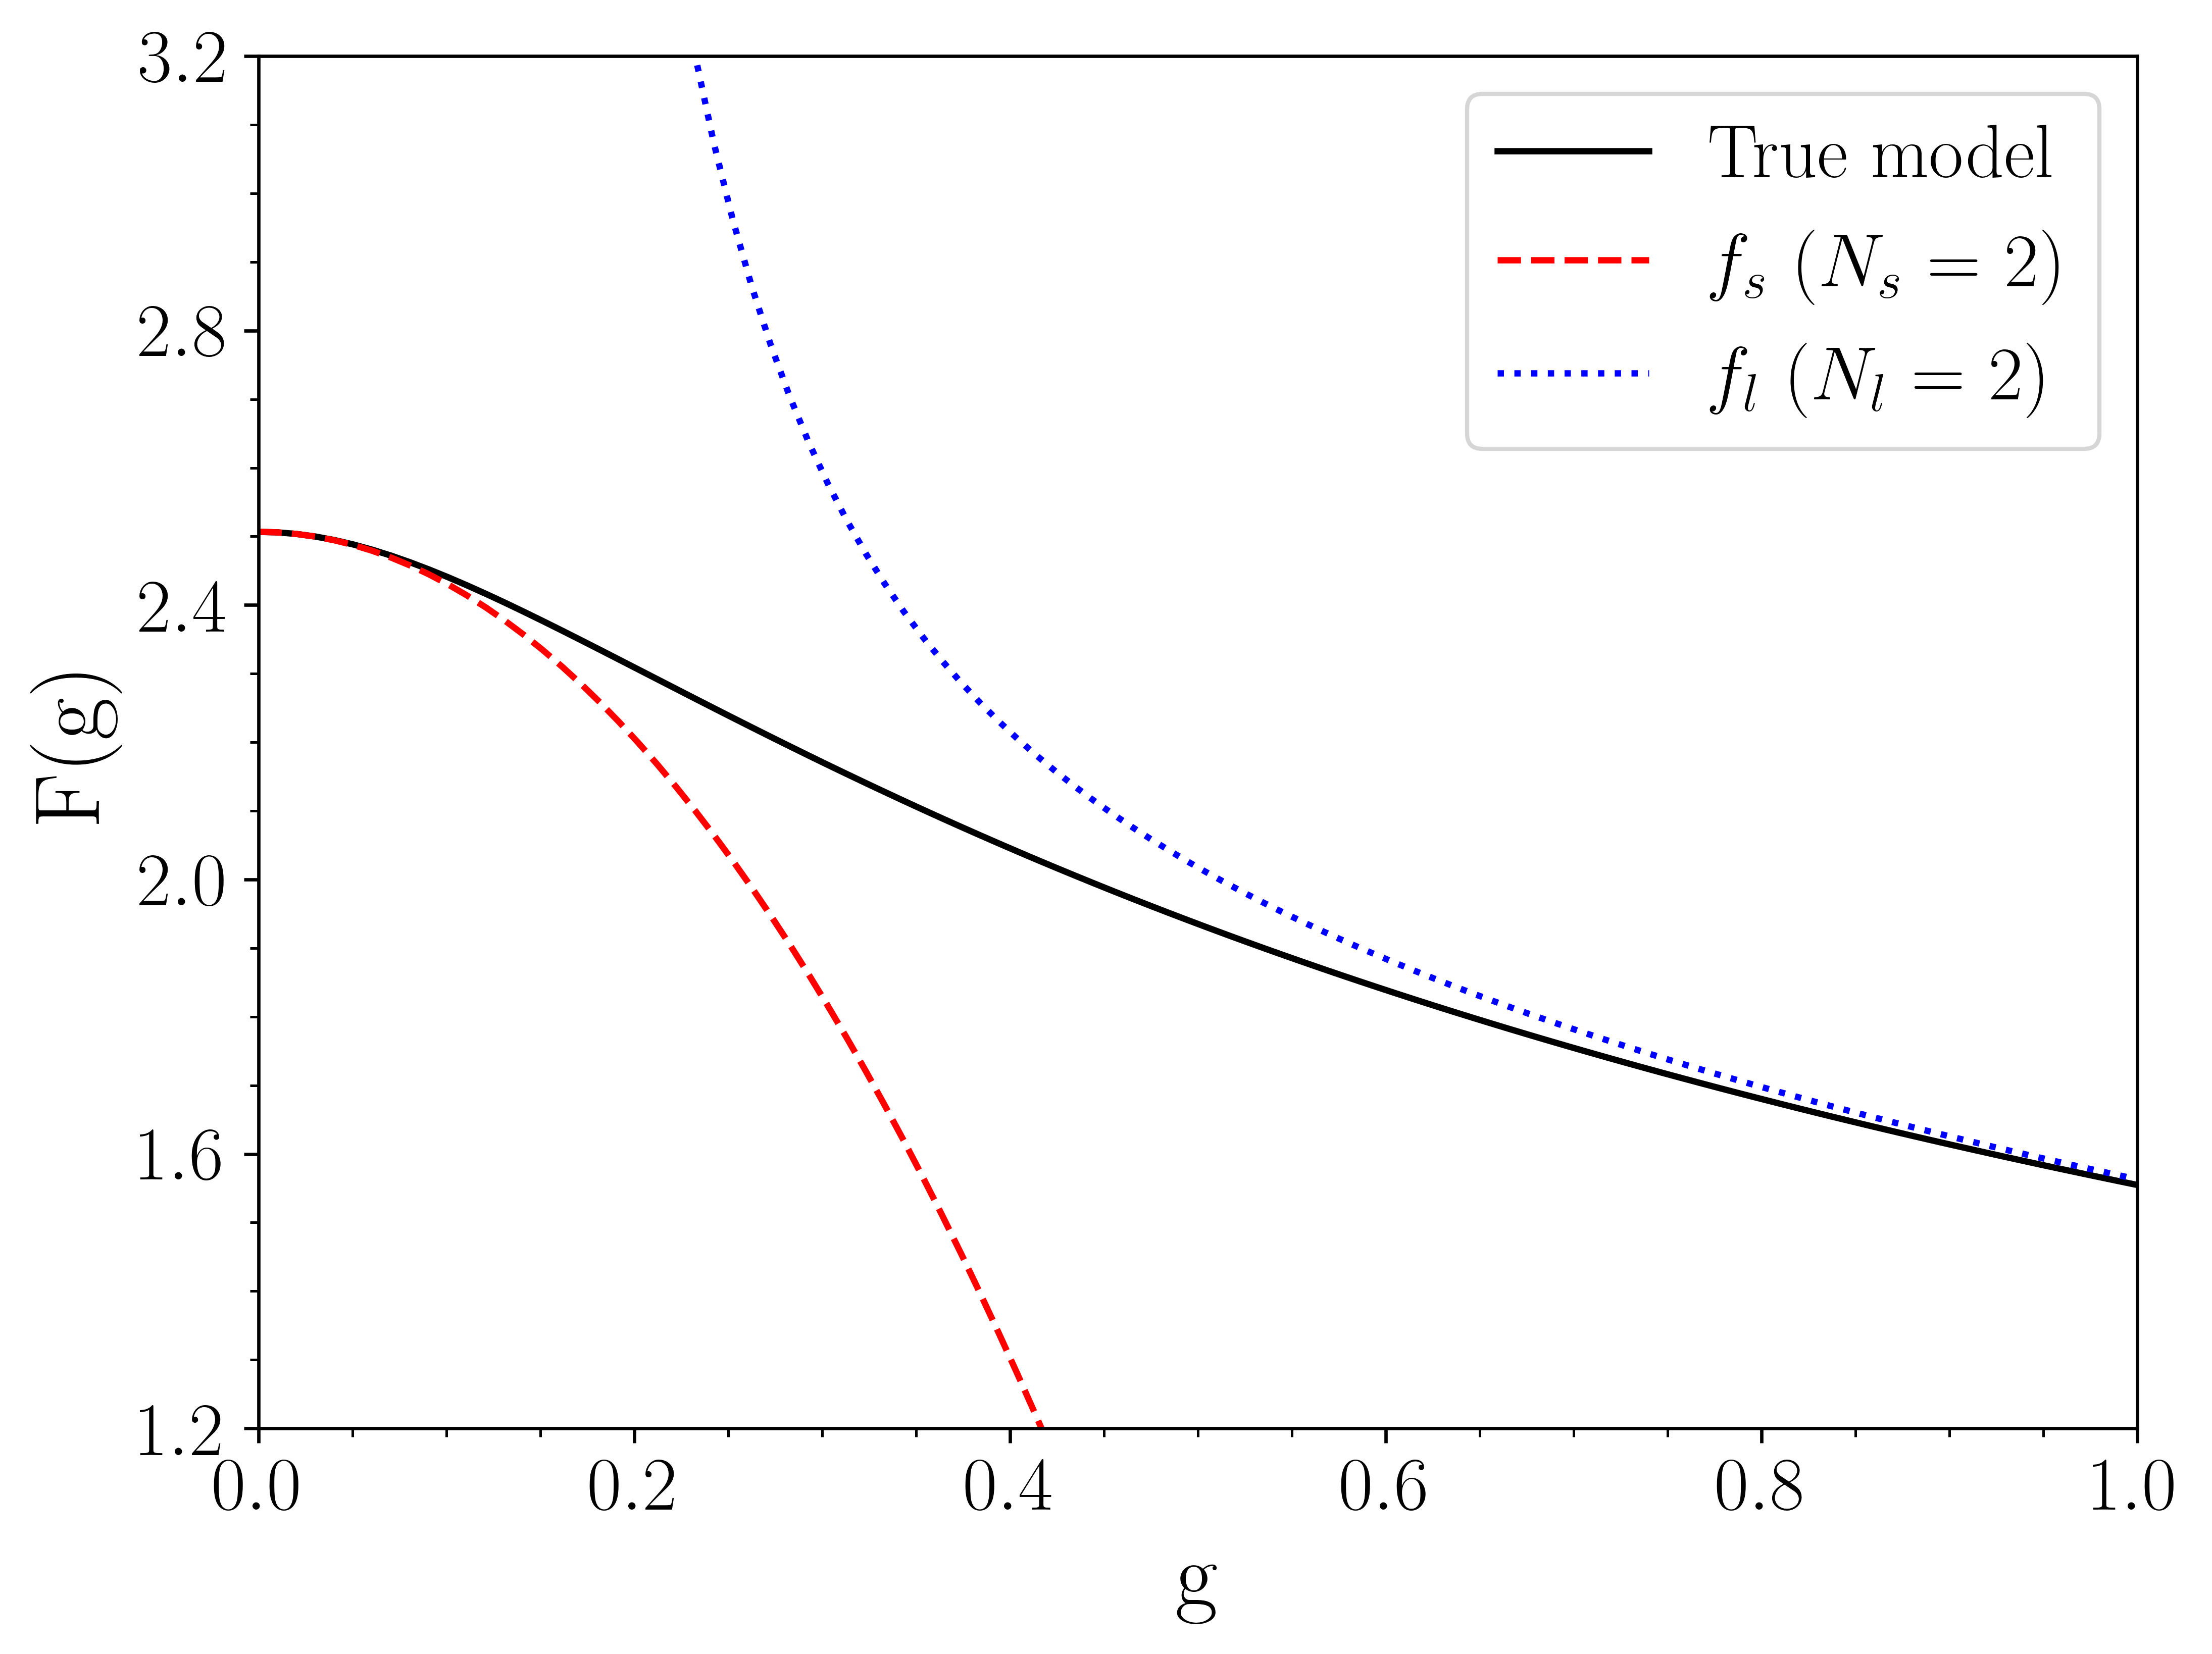

In [3]:
#set up the linspace for input variable g and N_s and N_l
g = np.linspace(1e-6,1.0,100)
ns = np.array([2])
nl = np.array([2])

#call the plot_models() function from Models()
m = LMM(ns, nl)
m.plot_models(g)

Now let's try to mix these two functions using the LMM() class. We'll need data in the gap, as this method relies on some data there. To do this, we estimate the length of the gap by eye and make a linspace over it with a few data points.

Data will be generated. What percent error would you like on your data (please enter a decimal)?0.01


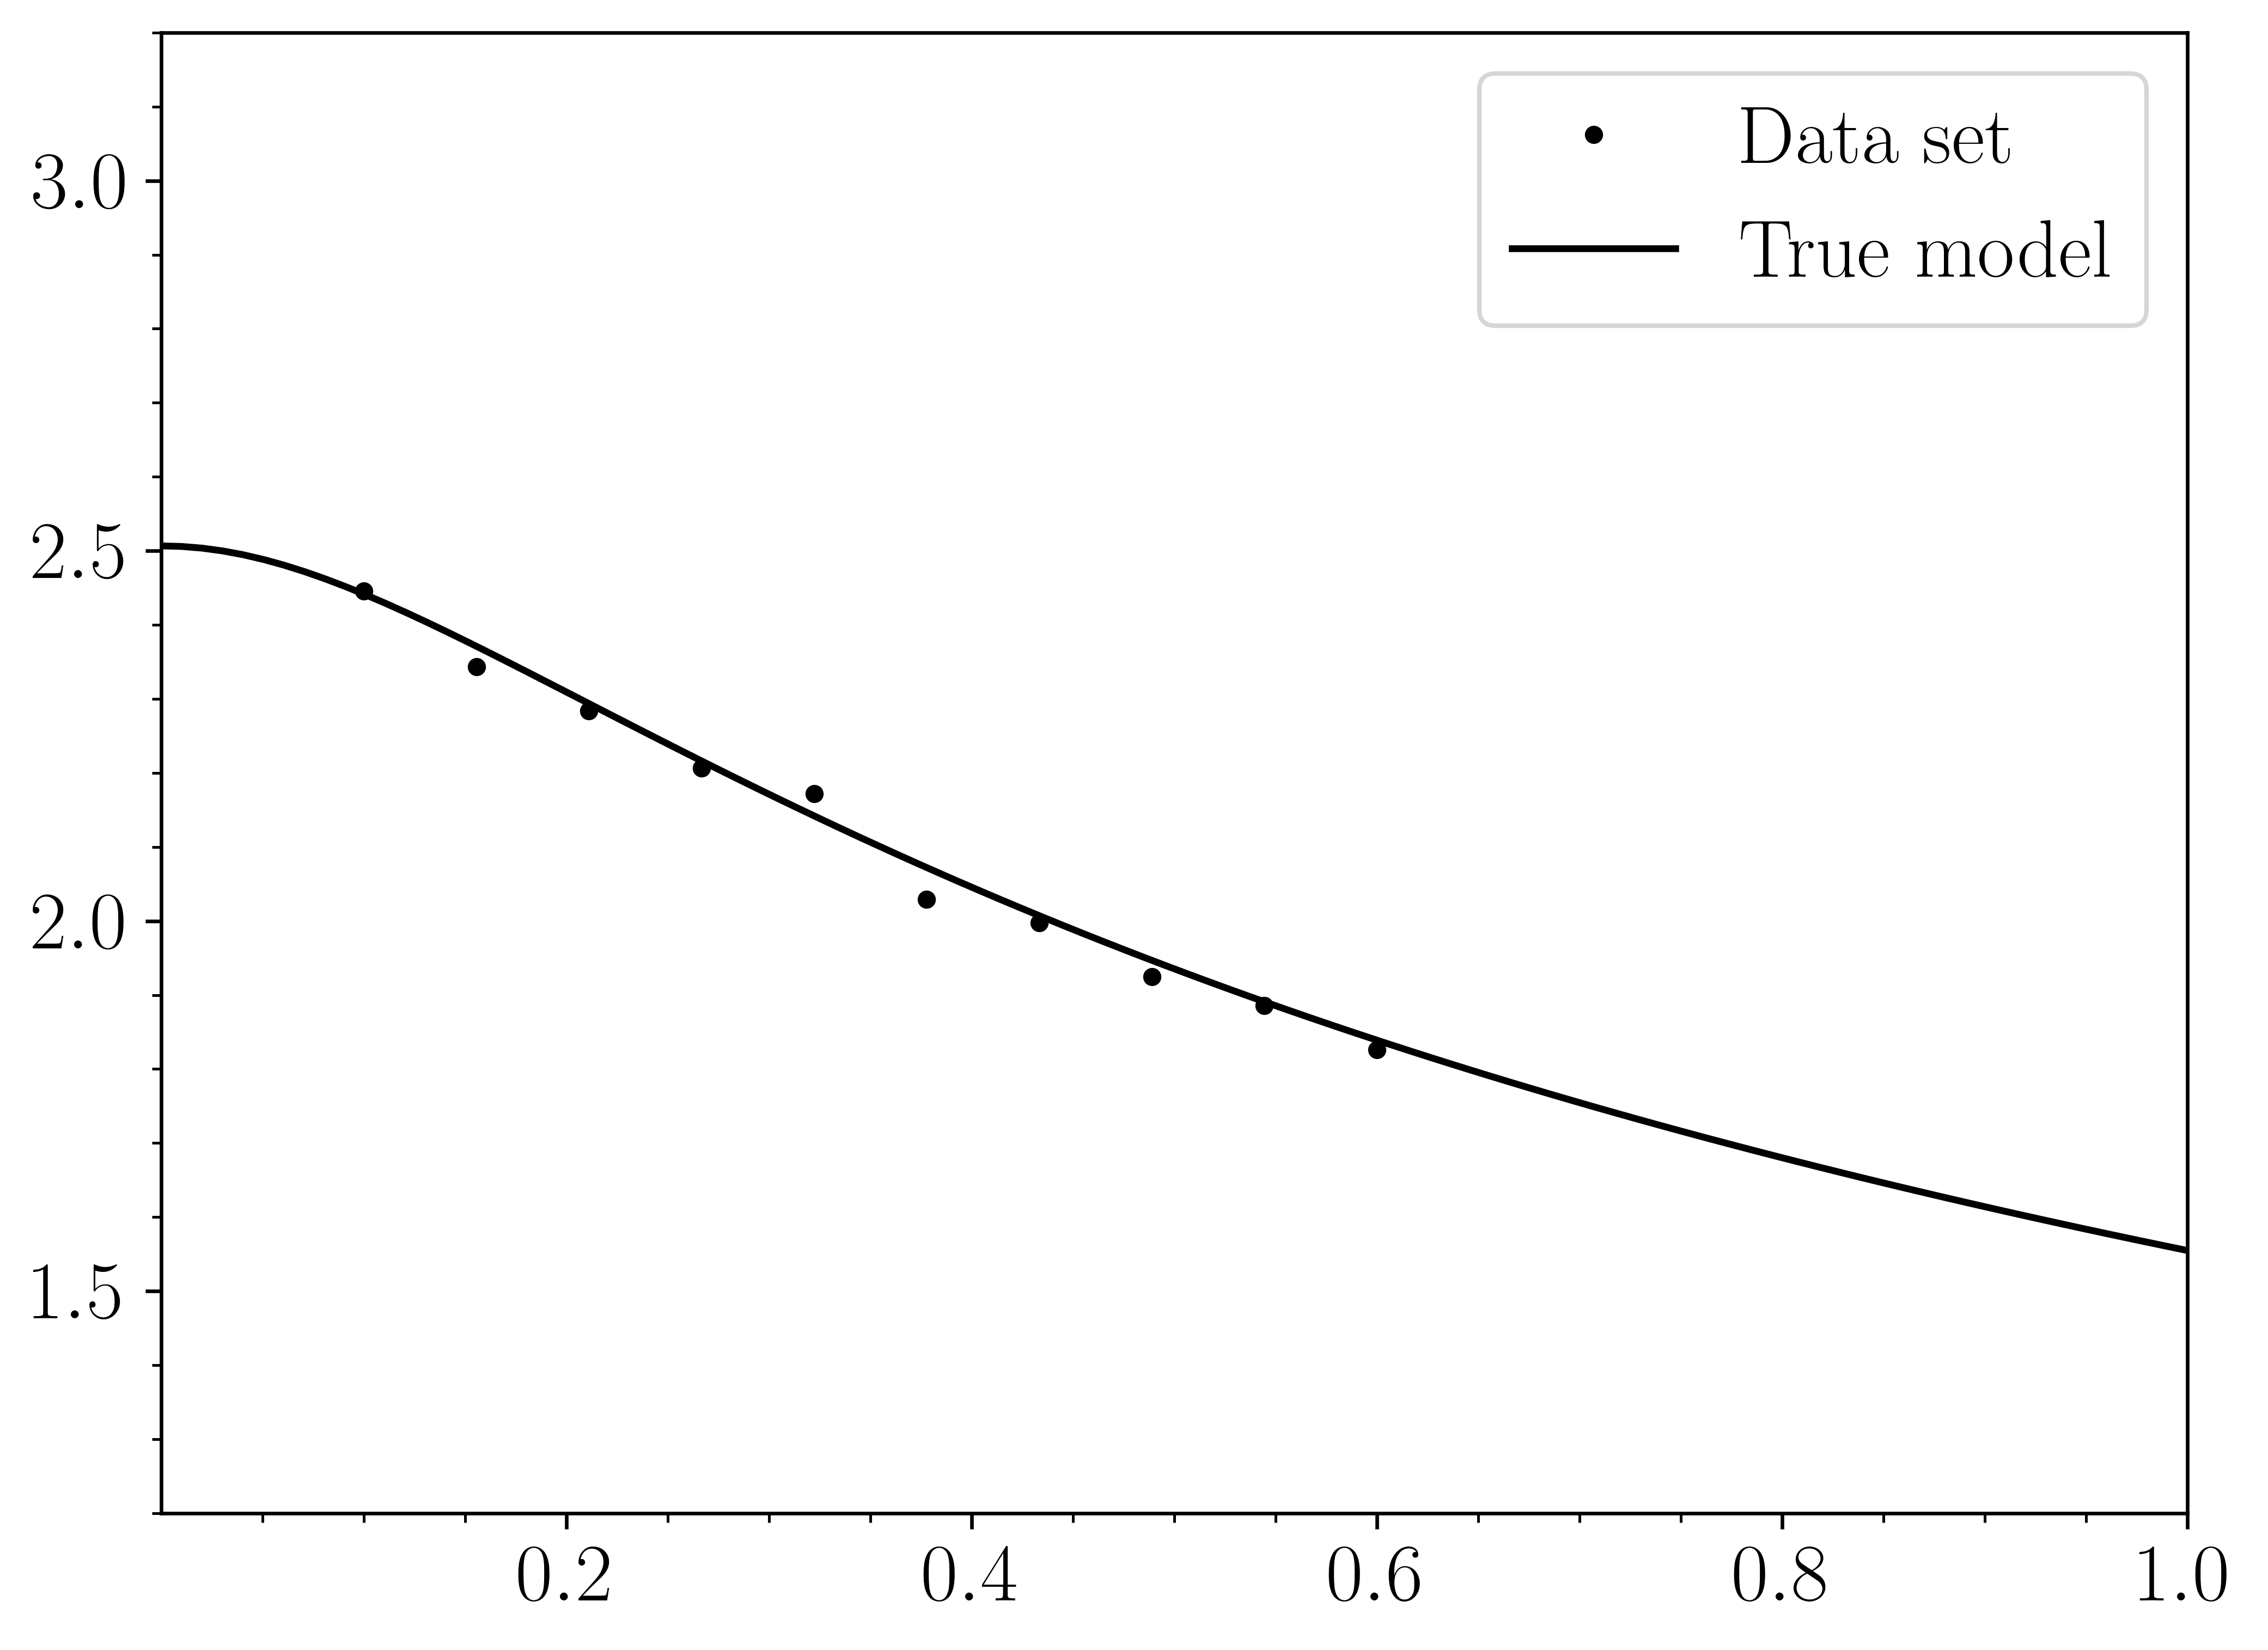

In [4]:
#make linspace for data
g_data = np.linspace(0.1, 0.6, 10)

#call the add_data() function to create the data
data, sigma = m.add_data(g, g_data)

Now we call the mixing function, __mixed_model()__, and give it this data. It will ask us which mixing function we wish to use, out of three options: logistic, cdf, and piecewise cosine. As discussed in the paper, the best option is the __piecewise cosine__. This mixing function will require emcee to sample 3 parameters, as we'll see later on in a plot we can generate with the results of the sampling. 

The equation the sampler will solve is the posterior written as 
$$
p(\theta|\mathbf{D}) = p(\theta)\prod_{i=1}^{n} \left\{ \alpha(g_{i}; \theta) ~\mathcal{N}(F^{N_s}_{s}(g_{i}), \sigma_{d_{i}}^{2} + \sigma_{N_s}^2) + (1 - \alpha(g_{i}; \theta))~ \mathcal{N}(F^{N_l}_{l}(g_{i}), \sigma_{d_{i}}^{2} + \sigma_{N_l}^2) \right\},
$$

where $\alpha(g;\theta)$ is this piecewise cosine mixing function (see Eq. (15) in the paper), the two individual models are written as Gaussian distributions, and their variances, $\sigma_{d_{i}}^{2} + \sigma_{N_s}^2$ and $\sigma_{d_{i}}^{2} + \sigma_{N_l}^2$, are combinations of the error on the data points ($\sigma_{d_{i}}^{2}$) and the theory error at each data point ($\sigma_{N}^2$). The prior $p(\theta)$ is given as three truncated Gaussians in the form

$$
p(\theta) = \mathcal{U}(\theta_{1} \in [0,b])~\mathcal{N}(\theta_{1}; \mu_{1}, 0.05)
        \times\mathcal{U}(\theta_{2} \in [\theta_{1},b])~\mathcal{N}(\theta_{2}; \mu_{2}, 0.05)
        \times\mathcal{U}(\theta_{3} \in [\theta_{2},b])~\mathcal{N}(\theta_{3}; \mu_{3}, 0.05).
$$

The means $\mu$ and ranges $b$, as well as the variance (given there as 0.05 for each prior) are dependent upon the series expansion chosen and therefore can be altered as need arises. 

__NOTE__: If you merely choose some data points and run the code, you will notice that, when all is said and done, the parameters may not be located in very accurate spots in the gap. This *could* be because the Priors() function __lpdf()__ needs some adjusting, by __you__! Your freedom in the toy model so far is to adjust the information in the Priors() class so that the best starting points for the sampler are given to it. As mentioned above, the mean and variance of the Gaussian prior can be changed to better match where one would expect that parameter to be located, and the uniform prior helps the sampler keep the parameters from crossing when they are sampled. They __must not cross__, else the sampler will not be happy and the mixing will not work properly. Hence, adjusting the uniform prior so that the parameters remain in their own regions, but allowing them some wiggle room via the Gaussian variance, is the best method when dealing with the piecewise cosine mixing function.

So far, the best way change these parameters is by directly altering the class file priors.py yourself, but in the future when more flexibility for users is added, __lpdf()__ will become a function you can directly input into the class without changing anything internally in the package. 

In [5]:
#call mixed_model()
chain, trace = m.mixed_model(g_data, data, sigma)

What mixing function would you like to use: logistic, cdf, or cosine?cosine
Enter the number of steps per walker.3000
Using 20 walkers with 3000 steps each, for a total of 60000 samples.
Calculation finished!
Duration = 1 min, 17 sec.
How many burn-in samples per walker?200
Using 200 samples as burn-in, for a total of 4000 burn-in samples.
(3, 56000)


We have the samples in hand now. However, we would like to thin them so that we cut out any correlations in the samples. This allows us to capture the most important features of the samples. Let's do this using the autocorrelation length in the function __stats_chain()__. The results for the mean and median of the mixing function parameter distributions will also be returned from this function, along with the thinned array for any further work we wish to do with the sample results.

The autocorrelation times are: [25.62013955 21.48527376 25.12067738]


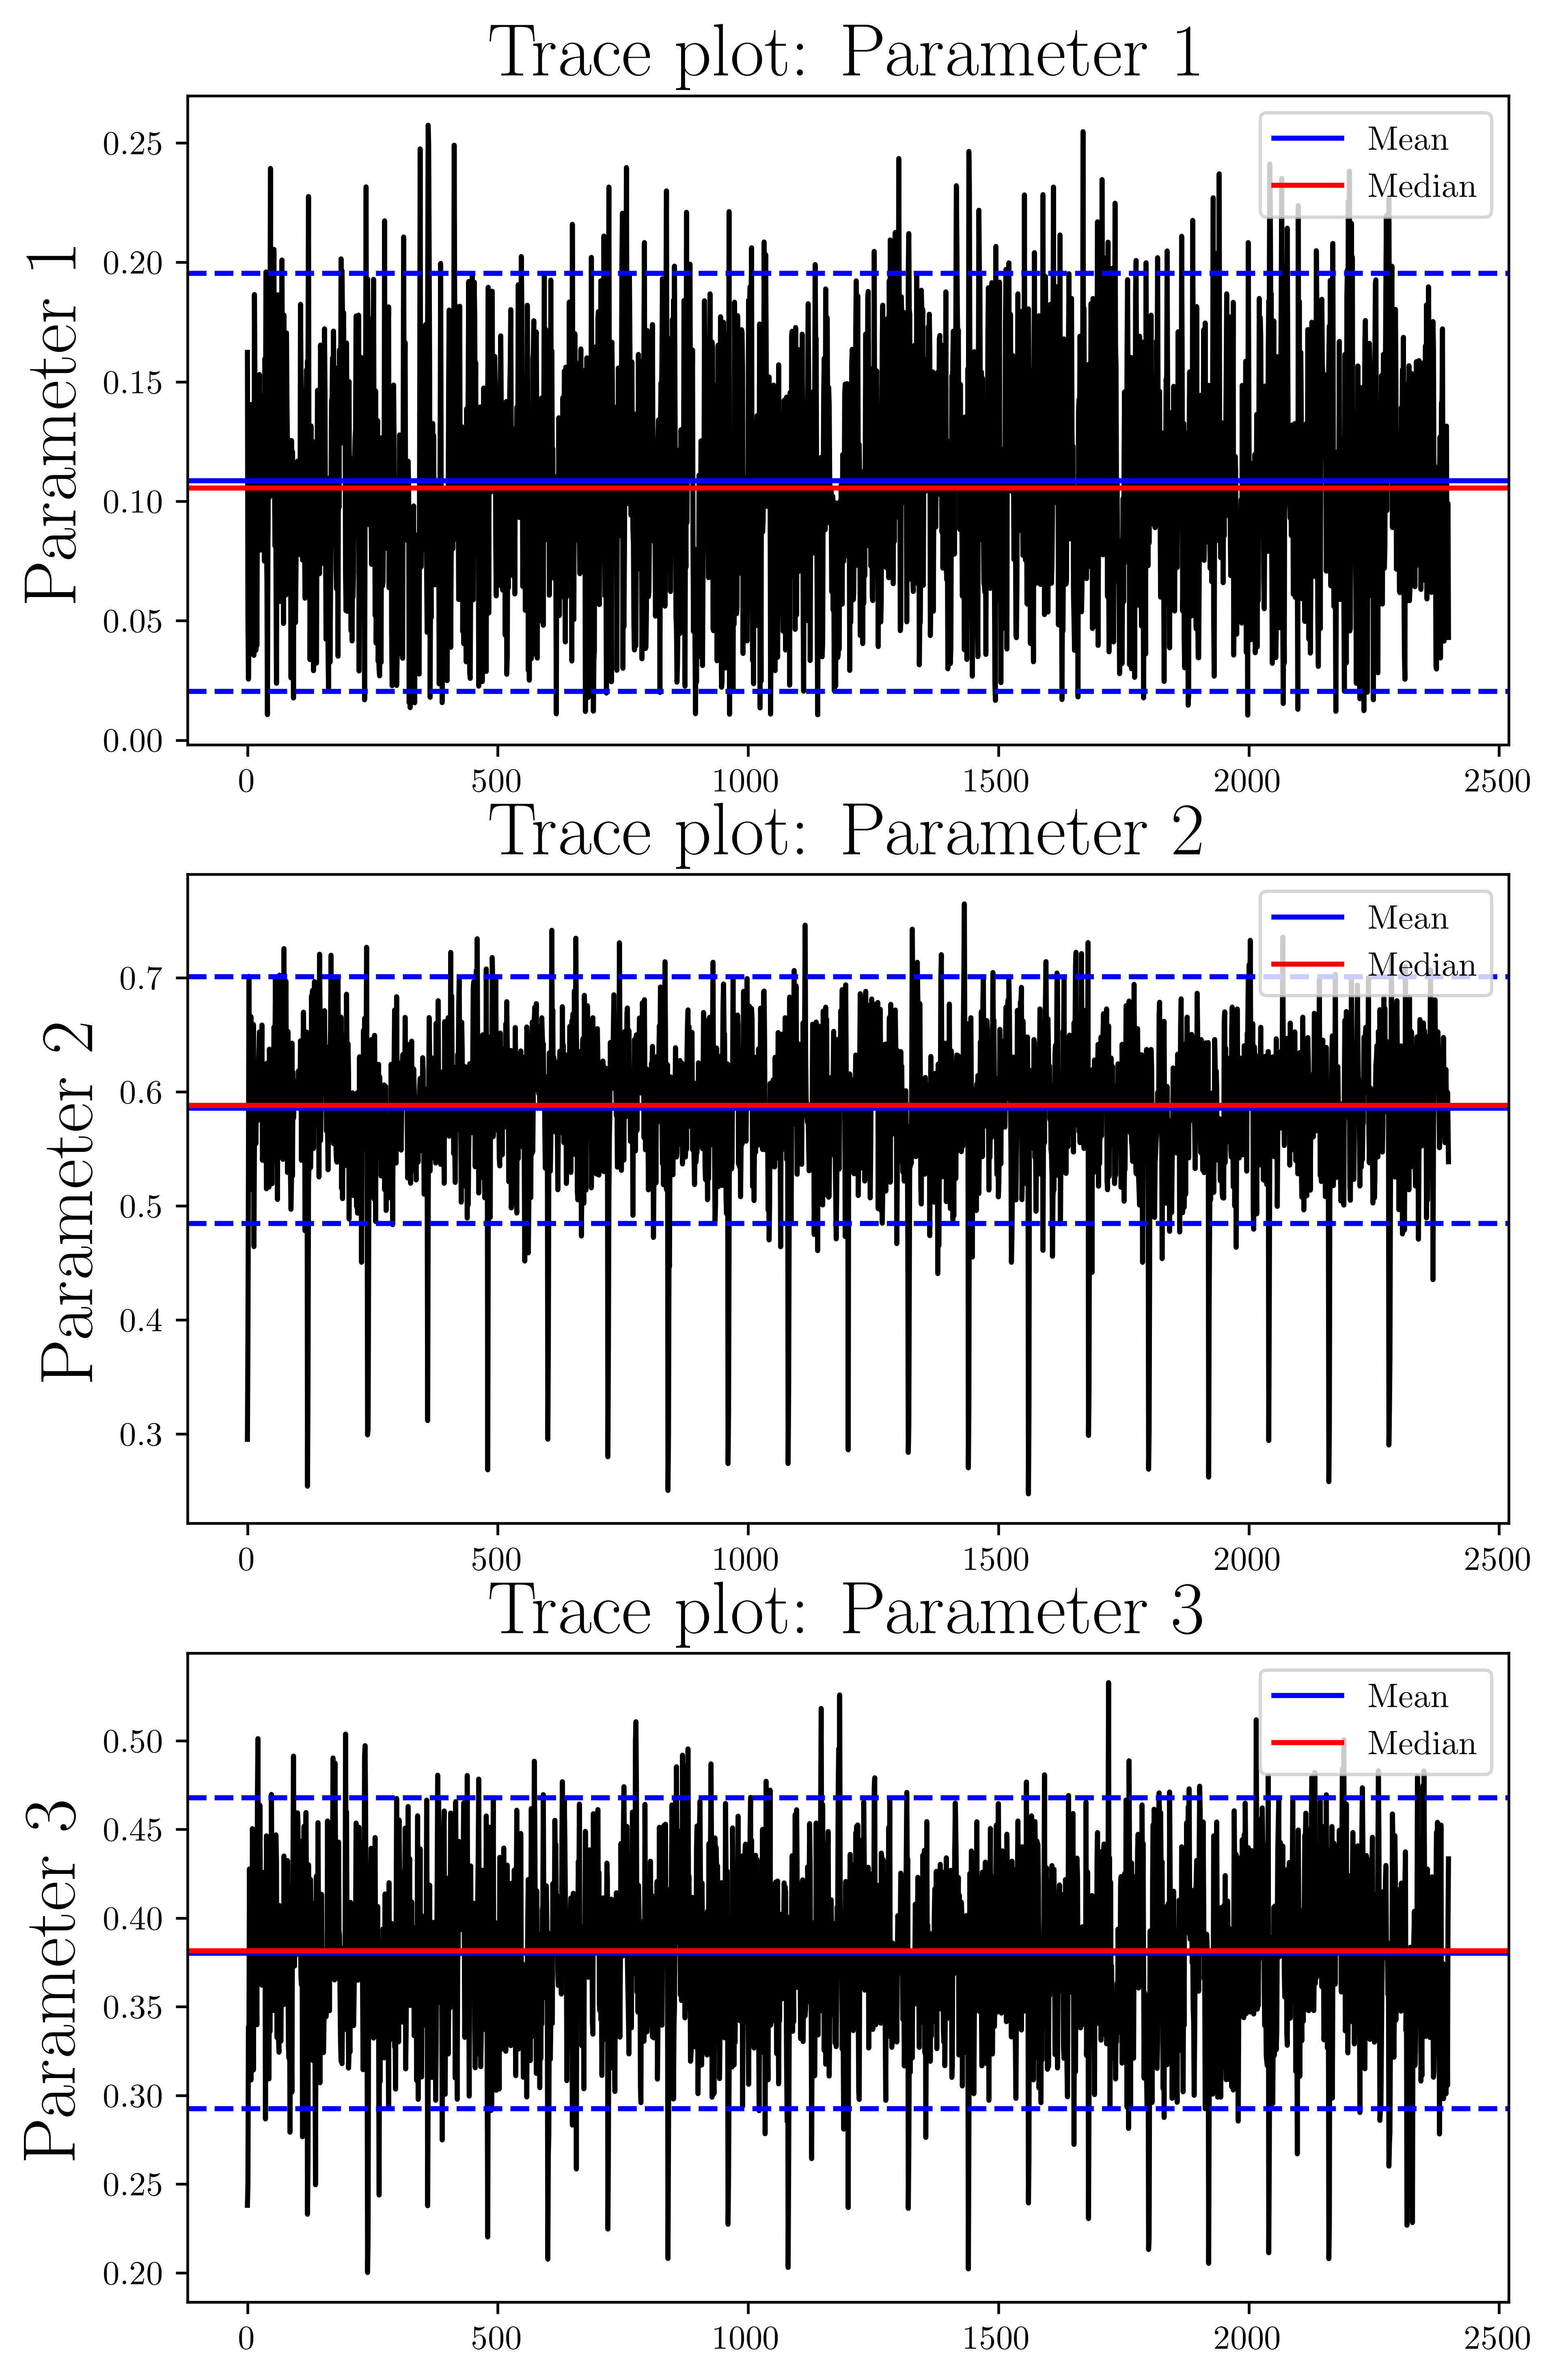

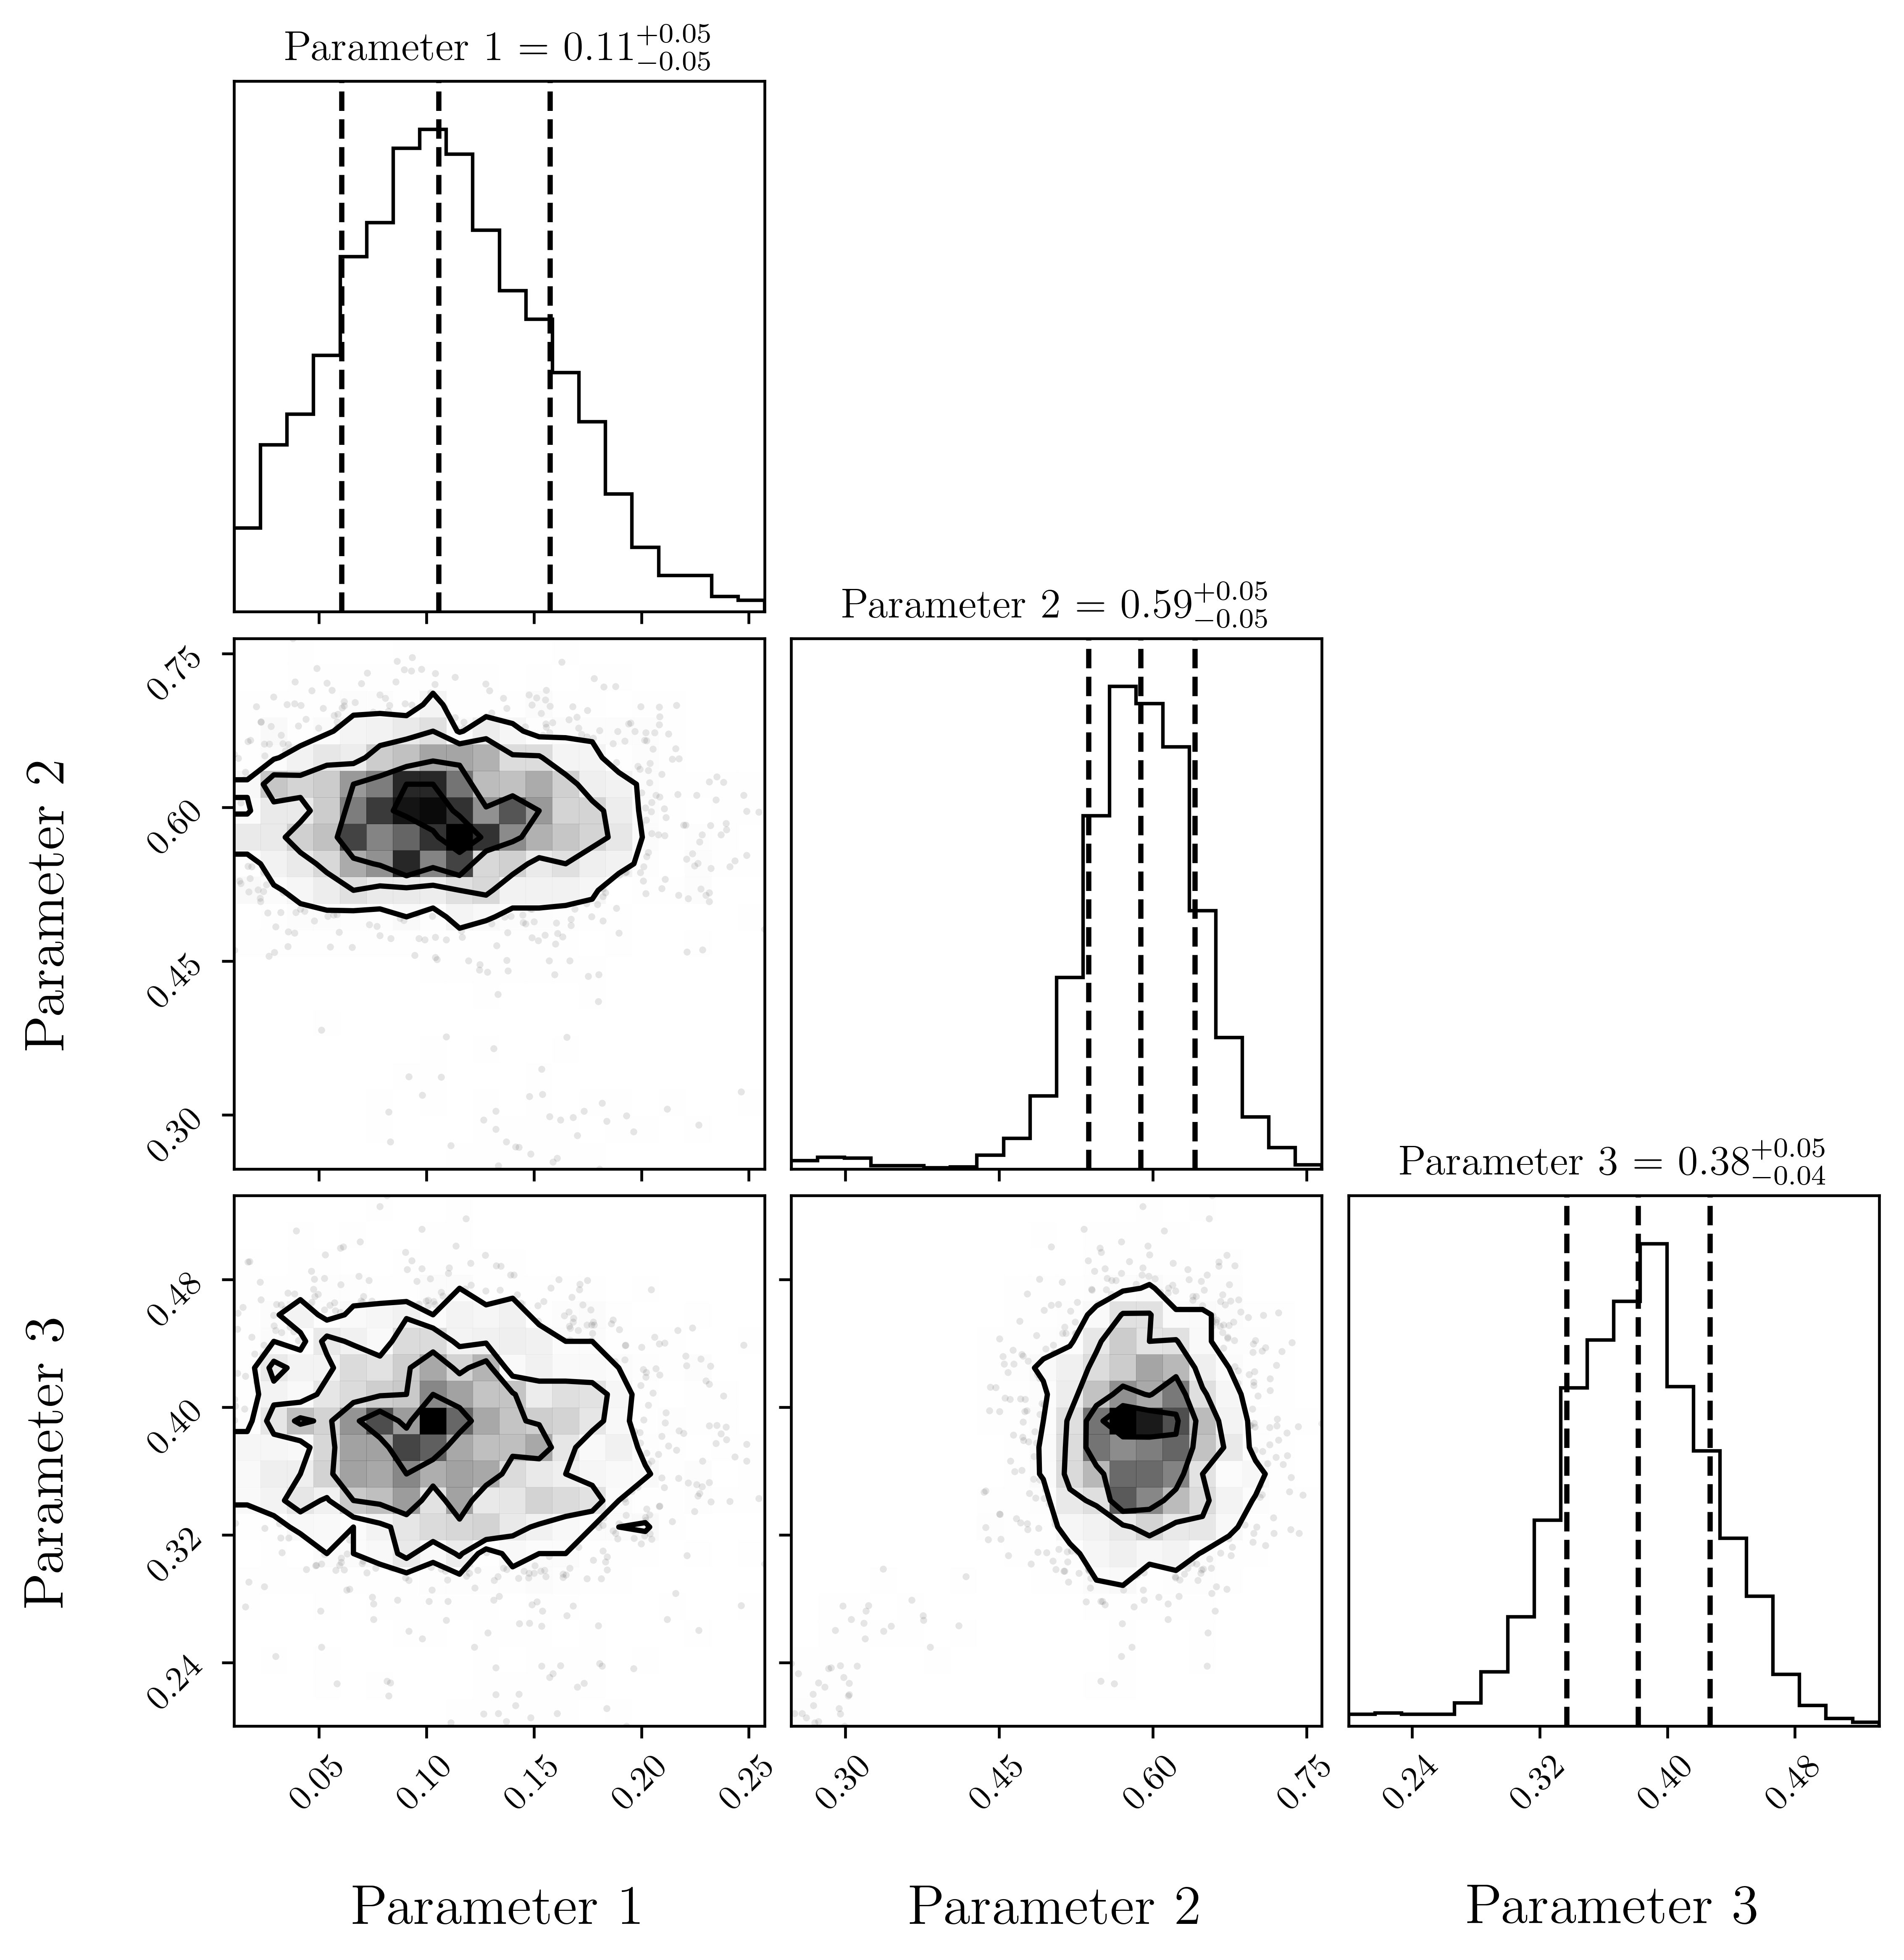

The median values are: [0.10567859 0.588281   0.38158904]
The mean values are: [0.10869803 0.58596069 0.380242  ]


In [6]:
thin_array, mean, median = m.stats_chain(chain, parameters=3)

Now that we know these values, we can take a look at the mixing function we used (before looking at the final PPD result of the mixed model). To do this properly, we employ the MAP value results from the function __MAP_values()__, instead of using the mean or the median, as these can be misleading when one's distributions are not purely Gaussian. We then overlay the MAP values with the mixing curve itself, to show where the parameter values have landed in $g$. 

MAP values:  [0.10312086 0.59173237 0.38573599]


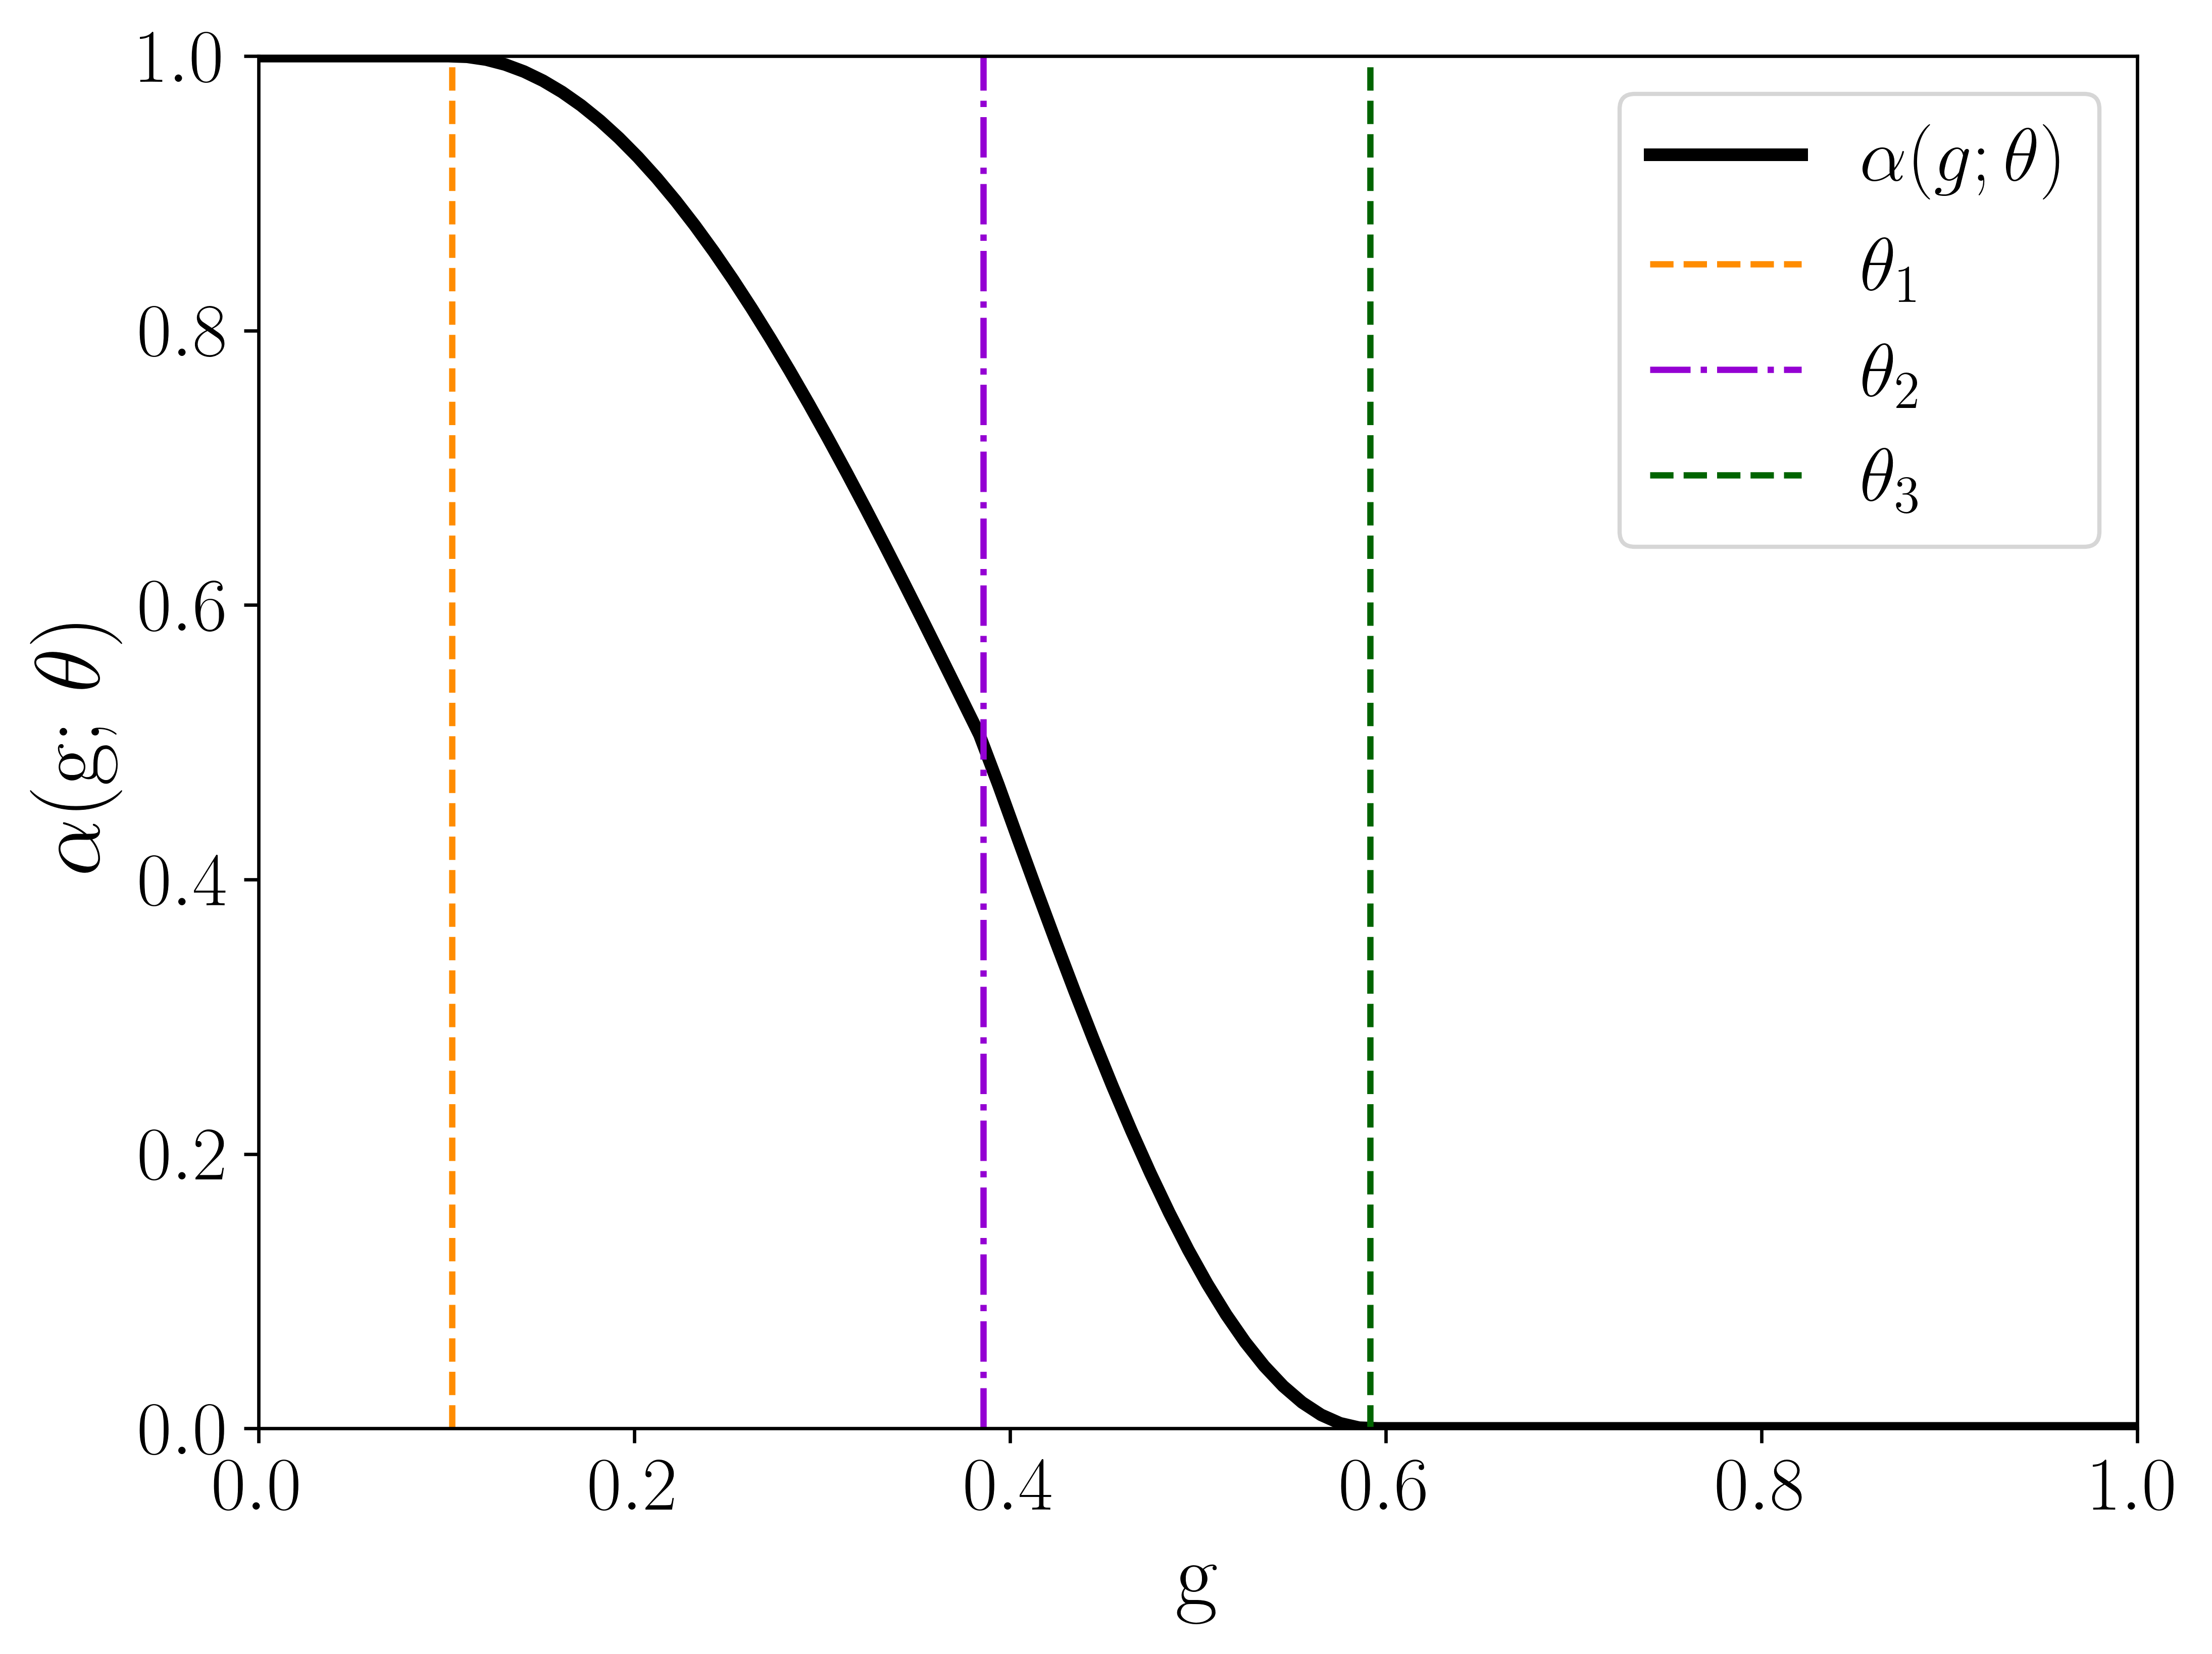

In [10]:
map_values = m.MAP_values(thin_array, g, g_data, data, sigma)

Now we want to calculate the mixed model, which means we need to obtain the posterior predictive distribution, or __PPD__, as a function of points in $g$ that can be spread across the input space. For this, we make another array in $g$ and call the __ppd()__ function, employing our thinned trace as well.

The PPD equation that is solved in this code is given as 

$$
p(\tilde y(g)|\theta, \mathbf{D}) = \sum_{j=1}^{M} \alpha(g; \theta_{j}) ~\mathcal{N}(F^{N_s}_{s}(g), \sigma_{d_{i}}^{2} + \sigma_{N_s}^2) + (1 - \alpha(g; \theta_{j}))~ \mathcal{N}(F^{N_l}_{l}(g), \sigma_{d_{i}}^{2} + \sigma_{N_l}^2),
$$

much like before with the sampled posterior, except now we are predicting for a new observation $\tilde y(g)$.

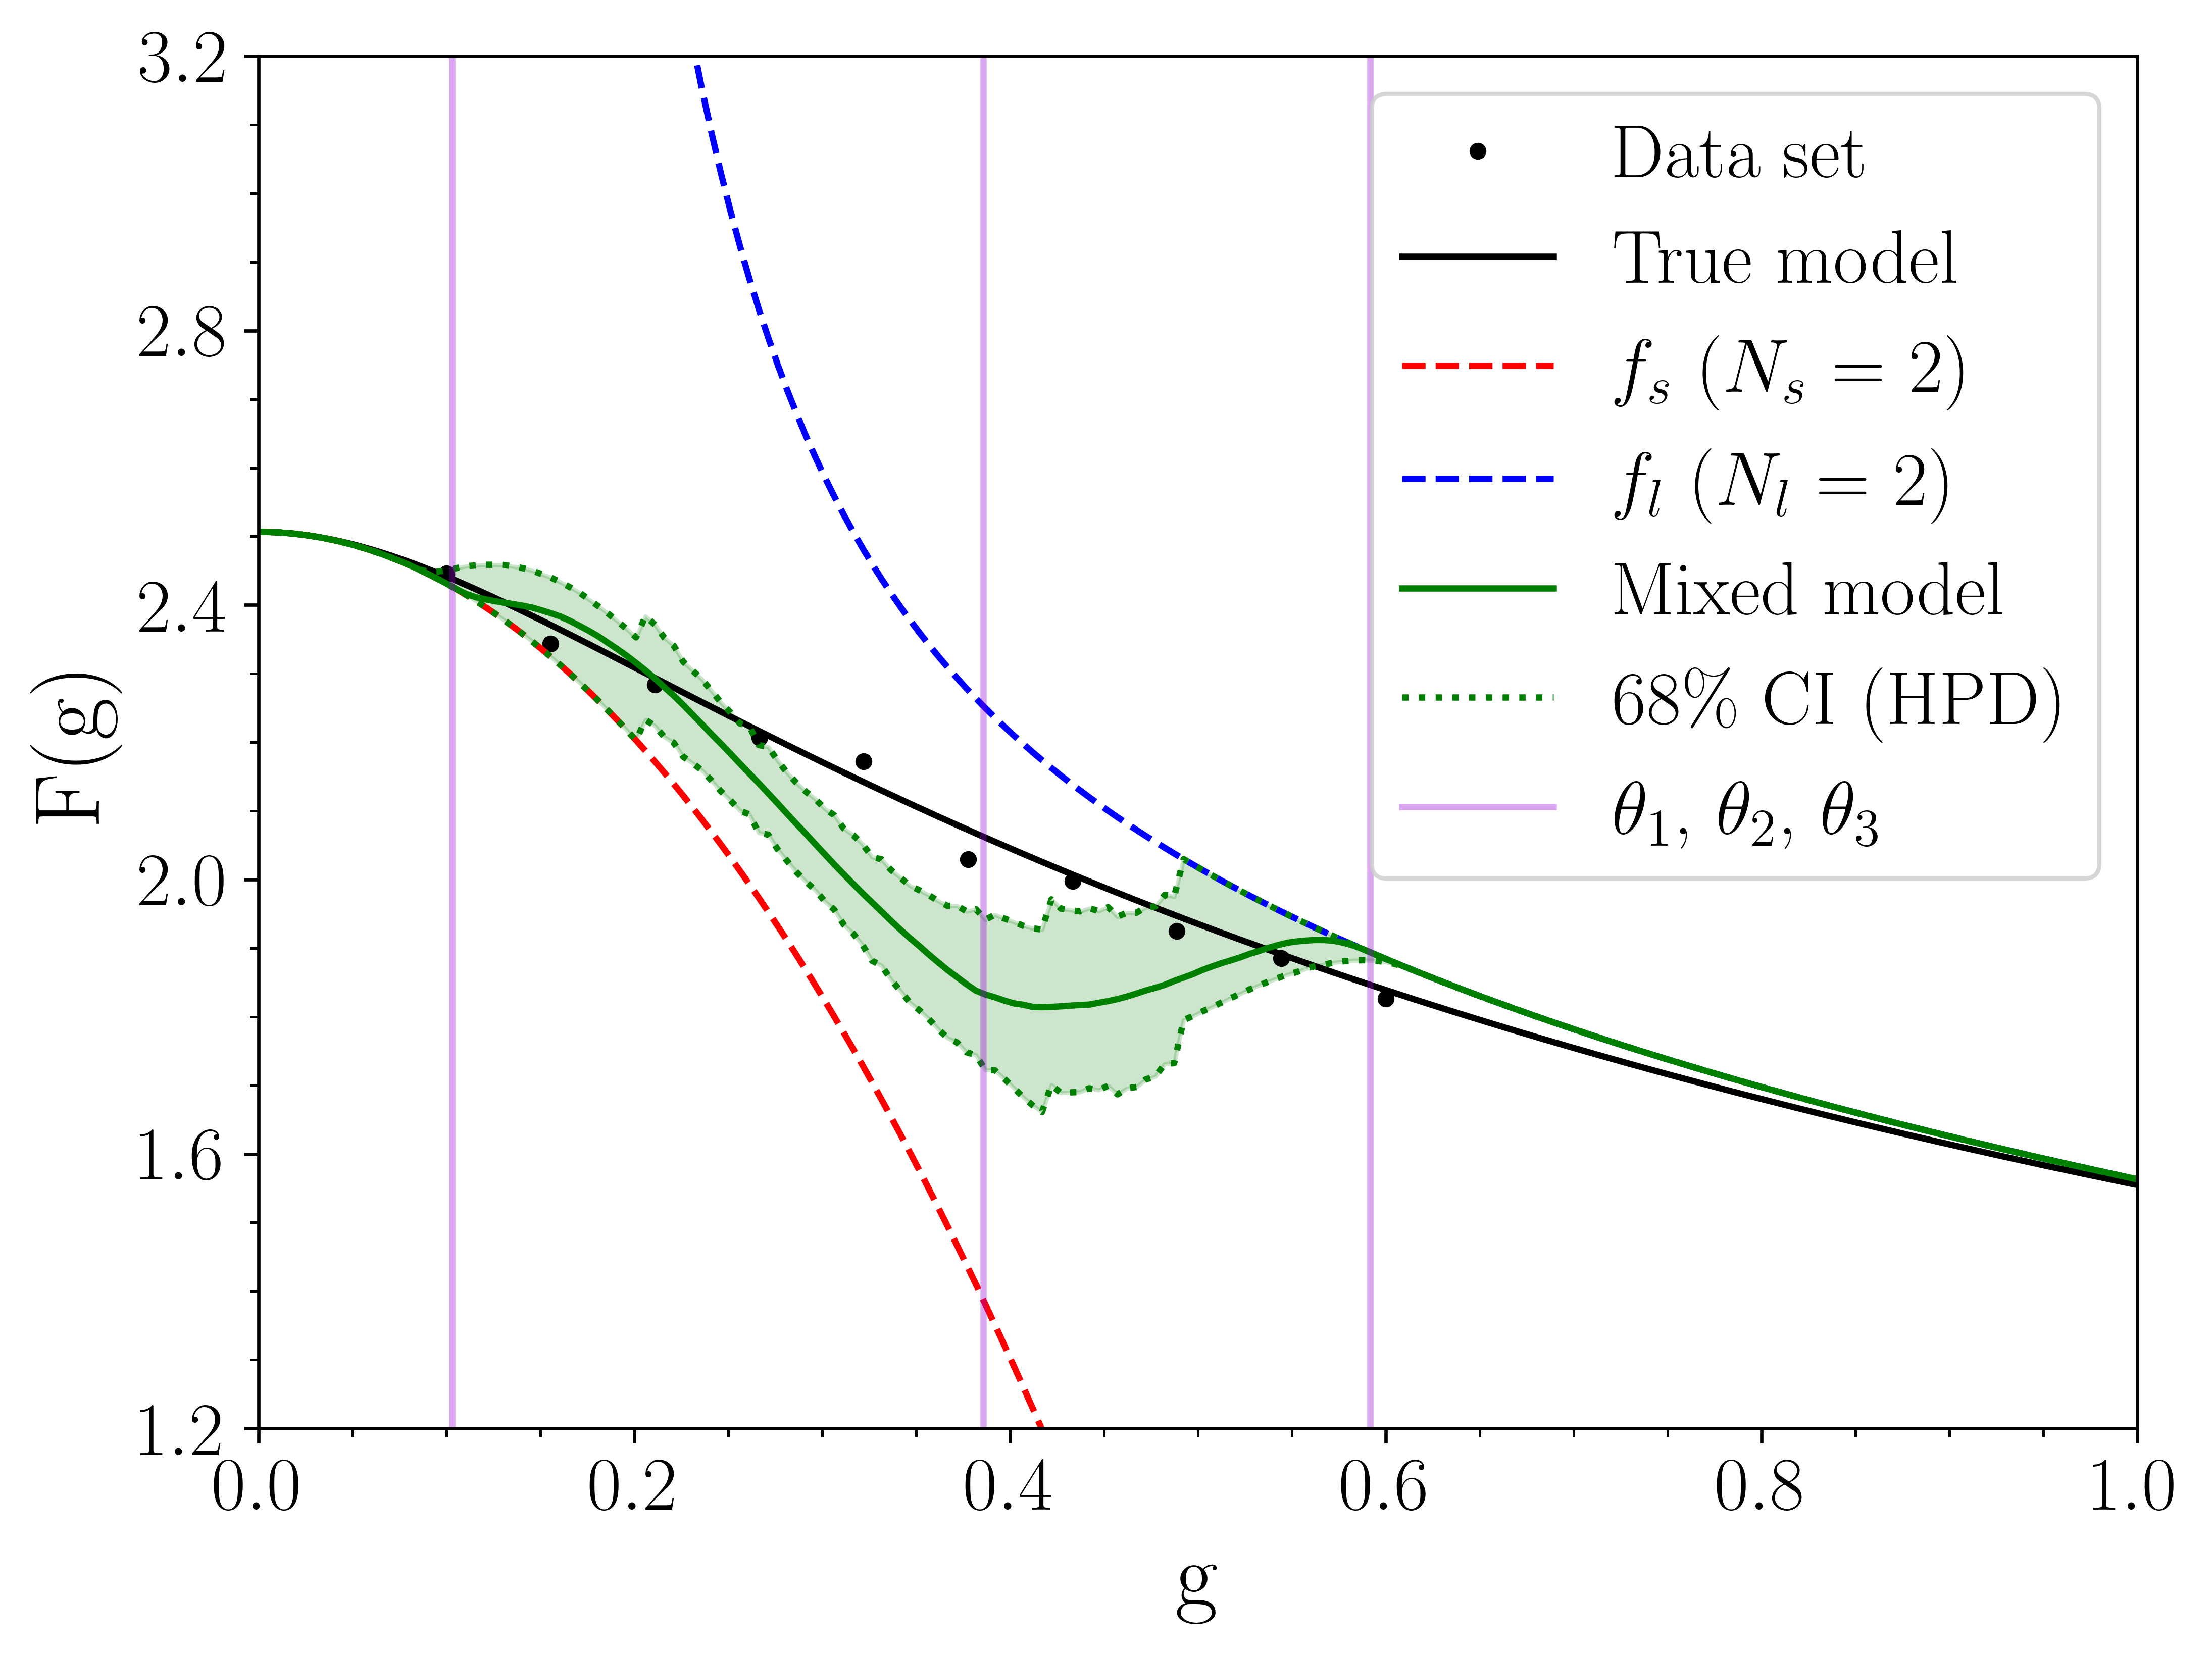

Would you like to save the plot to a file (yes/no)?no


In [13]:
#PPD linspace
g_ppd = np.linspace(1e-6, 1.0, 200)

#PPD calculation using ppd() and MAP parameter values
ppd_result = m.ppd(thin_array, map_values, g_data, g_ppd, data, 0.68)

And that's the mixed model result! The green curve is our PPD result, which has been generated using the median of the posterior at each point in $g$. The green band is the credibility interval at 68%, using the HPD (Highest Posterior Density) method, which is contained in the function __hpd_interval()__ in the LMM() class, and does its work by finding the smallest region with 68% of the posterior density and plotting it. 

It is quite evident, however, that the mixed model here is not matching the true curve very well at all. In the next notebook (__Bivariate_BMM__) we will look at another method to mix these two series expansions together. 

Written by: Alexandra Semposki (06 June 2022)